# Análisis Exploratorio de Datos
  *Alberto De león*

*¿Cómo se pueden predecir los patrones temporales y geográficos de homicidios en Colombia utilizando datos históricos de la API de Datos Abiertos y técnicas de Machine Learning?*

## Descripción de variables 
<br>

* homicidio_key: Inidentificador único de cada hecho.
* cod_depto: Llave secundaria que conecta con la dimensión departamento.
* cod_mpio: Llave secundaria que conecta con la dimensión municipio.
* sexo_key: Llave secundaria que conecta con la dimensión sexo.
* fecha_hecho: Fecha en que ocurrió el hecho.
* Cantidad: Cantidad de victimas resgistradas en un mismo hecho.
<br>

* fecha: Fecha en la que ocurrió el hecho
* año: Valor dimensional para el erriquecimiento del analisis (Año en que ocurrió el hecho)
* mes: Valor dimensional para el erriquecimiento del analisis (int Mes en que ocurrió el hecho)
* día: Valor dimensional para el erriquecimiento del analisis (int Día en que ocurrio el hecho)
* Trimestre: Valor dimensional para el erriquecimiento del analisis (int Trimestre en que ocurrió el hecho)
* semana_año: Valor dimensional para el erriquecimiento del analisis (int Representa la semamna del año en que ocurrio el hecho)
* nombre_mes: Valor dimensional para el erriquecimiento del analisis (Cadena de texto que que representa el nombre del mes en que ocurrió el hecho)
* nombre_dia_semana: Valor dimensional para el erriquecimiento del analisis (Cadena de texto que represente el nombre del día de la semana en la que ocurrió el hecho)
* es_fin_semana: Valor booleano que indica si era fin de semana al moneto del hecho ¿sí o no?
* es_festivo: Valor booleano que indica si era festivo al momento del hecho ¿sí o no?
<br>

* sexo: sexo de la victima del hecho.
<br>

* cod_mpio: Código del municipio en que ocurrió el heaho de acuerdo a la división politico administrativa de Colombia.
* cod_depto: Código del departamento en ocurrió el hecho de acuerdo a la division politico administrativa de Colombia.
* tipo: Registra el tipo de múnicipio en que ocurrió el hecho: municipio, isla o area no municipalizada.
* latitud: Coordenada del municipio  en la que ocurrió el hecho.
* logitud: Coordenada del municipio  en la que ocurrió el hecho.
<br>

* cod_deptp:Código del departamento en ocurrió el hecho de acuerdo a la division politico administrativa de Colombia.
* nom_depto: Nombre del departmento
* latitud: Coordenada del departamento  en la que ocurrió el hecho.
* longitid: Coordenada del departamento  en la que ocurrió el hecho.

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

In [2]:
# Comprobación de la conexion al contenedor
print(f'Python: {sys.version}')
print(f'Ejecutando en: {sys.prefix}\n')

# Conexión a la base de datos
load_dotenv('/app/.env')
DW_USER = os.getenv('DW_USER')
DW_PASSWORD = os.getenv('DW_PASSWORD')
DW_HOST = 'datawarehouse'
DW_PORT = '5432'
DW_DB = os.getenv('DW_DB')
connection_string = f"postgresql://{DW_USER}:{DW_PASSWORD}@{DW_HOST}:{DW_PORT}/{DW_DB}"
engine = create_engine(connection_string)

# Probar conexión
with engine.connect() as conn:
    result = pd.read_sql("SELECT current_database(), current_user;", conn)
    print("✅ Conexión exitosa!")
    print(f"📊 Base de datos: {result.iloc[0, 0]}")
    print(f"👤 Usuario: {result.iloc[0, 1]}")

Python: 3.12.12 (main, Dec 30 2025, 00:43:35) [GCC 14.2.0]
Ejecutando en: /usr/local

✅ Conexión exitosa!
📊 Base de datos: homicidios_dw
👤 Usuario: dw_user


### Obtención de los Metadatos

In [3]:
# Obtener metadatos de las tablas (sin cargar datos)
query_tables = """
SELECT 
    t.table_name,
    COUNT(c.column_name) as num_columnas,
    pg_size_pretty(pg_total_relation_size(quote_ident(t.table_name)::regclass)) as tamaño
FROM information_schema.tables t
LEFT JOIN information_schema.columns c 
    ON t.table_name = c.table_name 
    AND t.table_schema = c.table_schema
WHERE t.table_schema = 'public'
    AND t.table_type = 'BASE TABLE'
GROUP BY t.table_name
ORDER BY t.table_name;
"""
df_tables = pd.read_sql(query_tables, engine)
print("📋 Tablas en el Data Warehouse:\n")
print(df_tables.to_string(index=False))
print(f"\n📊 Total de tablas: {len(df_tables)}")

📋 Tablas en el Data Warehouse:

      table_name  num_columnas  tamaño
dim_departamento             4   40 kB
       dim_fecha            12 1280 kB
   dim_municipio             6  408 kB
        dim_sexo             2   56 kB
         etl_log            10   48 kB
 fact_homicidios             9   59 MB

📊 Total de tablas: 6


In [15]:
df = pd.read_sql_query('''
SELECT
    f.homicidio_key,
    d_s.sexo,
    d_f.fecha,
    d_f.año,
    d_f.nombre_mes,
    d_f.dia_semana,
    d_f.nombre_dia_semana,
    d_f.es_fin_semana,
    d_f.es_festivo,
    d_m.nom_mpio,
    d_m.tipo AS tipo_municipio,
    d_m.latitud AS latitud,
    d_m.longitud AS longitud,
    d_d.nom_depto,
    d_d.latitud,
    d_d.longitud,
    f.zona,
    f.cantidad as total_homicidios
FROM fact_homicidios f
INNER JOIN dim_sexo d_s
    ON f.sexo_key = d_s.sexo_key
INNER JOIN dim_fecha d_f 
    ON f.fecha_key = d_f.fecha_key
INNER JOIN dim_municipio d_m 
    ON f.cod_mpio = d_m.cod_mpio
INNER JOIN dim_departamento d_d
    ON f.cod_depto = d_d.cod_depto
''',
engine)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333267 entries, 0 to 333266
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   homicidio_key      333267 non-null  int64  
 1   sexo               333267 non-null  object 
 2   fecha              333267 non-null  object 
 3   año                333267 non-null  int64  
 4   nombre_mes         333267 non-null  object 
 5   dia_semana         333267 non-null  int64  
 6   nombre_dia_semana  333267 non-null  object 
 7   es_fin_semana      333267 non-null  bool   
 8   es_festivo         333267 non-null  bool   
 9   nom_mpio           333267 non-null  object 
 10  tipo_municipio     333267 non-null  object 
 11  latitud            333267 non-null  float64
 12  longitud           333267 non-null  float64
 13  nom_depto          333267 non-null  object 
 14  latitud            333267 non-null  float64
 15  longitud           333267 non-null  float64
 16  zo

In [48]:
# confirmación de la integridad de los datos.
min_homicidios = df['total_homicidios'].min().copy()
if min_homicidios >= 0:
    print('integridad de los datos confirmada')
else:
    print('Se identificaron posibles gaps\n')
    print(f' los pósibles gaps son: {min_homcidios}')

integridad de los datos confirmada


In [80]:
df['total_homicidios'].describe()

count    333267.000000
mean          1.001926
std           0.058455
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          14.000000
Name: total_homicidios, dtype: float64

In [85]:
df.describe(include=[object])

,sexo,fecha,nombre_mes,nombre_dia_semana,nom_mpio,tipo_municipio,nom_depto,zona
count,333267,333267,333267,333267,333267,333267,333267,333267
unique,4,8370,12,7,1025,3,33,2
top,MASCULINO,2003-01-01,Diciembre,Domingo,CALI,Municipio,VALLE DEL CAUCA,URBANA
freq,306414,144,29086,68301,32559,332793,65397,230971


## Obtener una vision general de los datos
## Parametros de visualización

In [47]:
# Diccionario con cósigos hexadeciamles utilizados en las gráficas
colores_sexo = {'MASCULINO': '#120A8F', 'FEMENINO': '#FD3A99', 'OTRO': '#FFD700',}
colores_zona = {'URBANA': '#FFD700', 'RURAL': '#2ECC71'}

In [9]:
#  Se crea sub df de la cantidad de homicidios por sexo.
df_sexo = df[['sexo','total_homicidios']].copy()

# Definir los valores a agrupar 
val_agrupar = ['NO REPORTA', 'SIN ESTABLECER'] # Valors tan pequeños que no son visibles en la gráfica

# Reemplazar los valores mnimos por el nombre OTRO.
df_sexo['sexo'] = df_sexo['sexo'].replace(val_agrupar, 'OTRO')

# Agrupar los datos por sexo
df_sexo_agrupado = (
    df_sexo
    .groupby(['sexo'])
    .sum()
    .reset_index()
)

In [11]:
# Viusalización de los porcentajes 
df_sexo_agrupado['%'] = df_sexo_agrupado['total_homicidios']/df_sexo_agrupado['total_homicidios'].sum()
df_sexo_agrupado

,sexo,total_homicidios,%
0,FEMENINO,26745,0.080097
1,MASCULINO,307037,0.919523
2,OTRO,127,0.000380


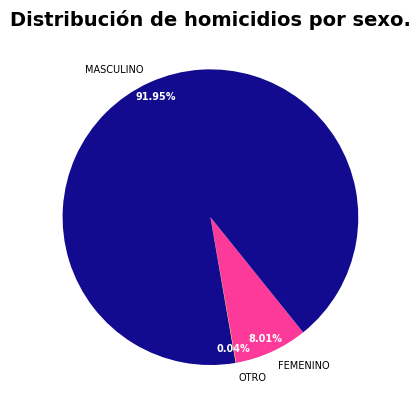

In [41]:
# Lista de colores ordenada
colores_ordenados =  [colores_sexo.get(nombre) for nombre in df_sexo_agrupado['sexo']]
# Se Visualizan los datos a través de un pie chart 
# Se capturan los retornos
patches, text, autotext = plt.pie(
    df_sexo_agrupado['total_homicidios'],
    labels=df_sexo_agrupado['sexo'],
    autopct='%1.2f%%',
    colors=colores_ordenados,
    textprops={'fontsize':7},
    startangle=280, 
    pctdistance=0.9
)

# Ahora se define el color blando para los porcentajes 
plt.setp(autotext, color='white', fontweight='bold')

plt.title(
    'Distribución de homicidios por sexo.',
    fontsize=14,
    fontweight='bold',
    pad=5,
    loc='center'
)

plt.show()

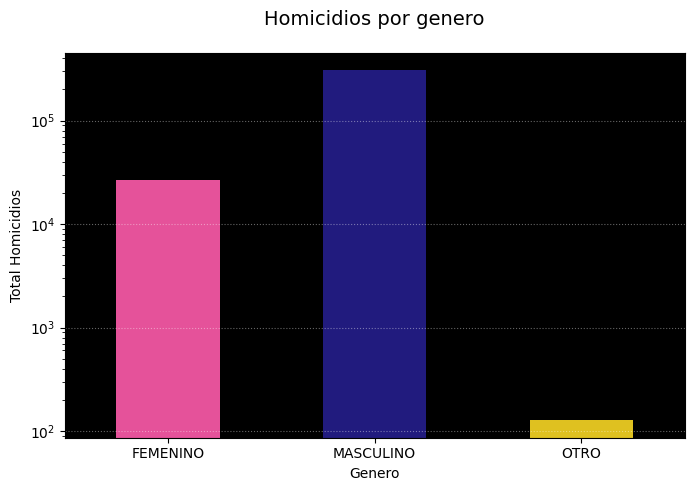

In [13]:
# Gestión de los patrones generales de visualización.
fig2, ax2 = plt.subplots(figsize=(8,5), facecolor='white')
ax2.set_facecolor('black')

# Visualización de la cantidad de homicidios por sexo.
sns.barplot(
    data=df_sexo_agrupado,
    x='sexo',
    y='total_homicidios',
    hue='sexo',
    palette=colores_sexo,
    estimator=sum,
    errorbar=None,
    ax=ax2,
    width=0.5
)

# Definición de parametros estéticos.
ax2.set_yscale('log')
ax2.set_title('Homicidios por genero', fontsize=14, color='black', pad=20)
ax2.set_xlabel('Genero', fontsize=10, color='black')
ax2.set_ylabel('Total Homicidios', fontsize=10, color='black')
ax2.grid(axis='y', color='white',linestyle=':', alpha=0.4)

### Evolución de la brecha de genero

In [14]:
# Consulta con los datos especificos para este analisis

df_evo_genero = pd.read_sql_query(
    '''
    SELECT
    f.año,
    f.mes,
    f.nombre_mes,
    f.fecha,
    s.sexo,
    SUM(h.cantidad) as total_victimas
    FROM fact_homicidios h
    INNER JOIN dim_fecha f
        ON h.fecha_key = f.fecha_key
    INNER JOIN dim_sexo s 
        ON h.sexo_key = s.sexo_key
    WHERE s.sexo IN ('MASCULINO', 'FEMENINO')
    GROUP BY 1, 2, 3, 4, 5
    ''',
    engine
)

In [54]:
# Agurpación de por meses para analisar tendencias 
df_pv_genero = df_evo_genero.pivot_table(
    index=['fecha', 'mes'],
    columns='sexo',
    values='total_victimas',
    aggfunc='sum'
).reset_index().fillna(0).copy()

# Asegurar que fecha sea datetime  
df_pv_genero['fecha'] = pd.to_datetime(df_pv_genero['fecha'])

# Poner fecha como el indice del DateTime
df_pv_genero.set_index('fecha', inplace=True)
df_pv_genero.head(5)

sexo,mes,FEMENINO,MASCULINO
fecha,,,
2003-01-01,1,5.0,138.0
2003-01-02,1,7.0,32.0
2003-01-03,1,2.0,50.0
2003-01-04,1,4.0,57.0
2003-01-05,1,7.0,38.0


Text(0.5, 1.0, 'Evolución de la Brecha de Genero (Femenino)')

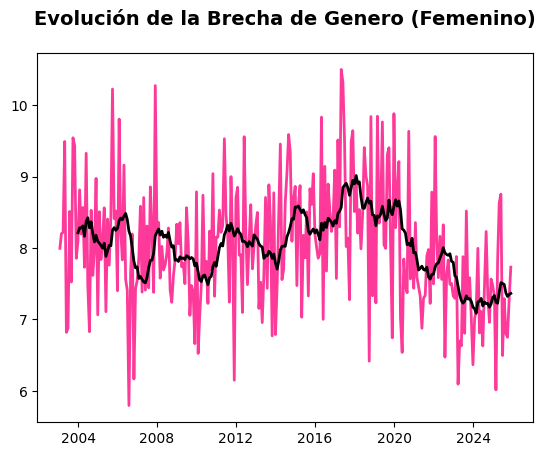

In [55]:
# Suavisación de la linea de tiempo 
df_trends = df_pv_genero.resample('ME').sum()

#Calcular el ratio de 
df_trends['ratio_masculino'] = (df_trends['MASCULINO'] / (df_trends['FEMENINO'] + df_trends['MASCULINO'])) * 100
df_trends['ratio_femenino'] = (df_trends['FEMENINO'] / (df_trends['FEMENINO'] + df_trends['MASCULINO'])) * 100

# Lineas de tendencias principal 
plt.plot(df_trends.index, df_trends['ratio_femenino'], color='#FD3A99', linewidth=2)

# Linea de tendencia suavizada 
plt.plot(df_trends.index, df_trends['ratio_femenino'].rolling(12).mean(),
         color='black', linewidth=2, linestyle='-', label='Tendencia Anual (Media Movil)')
plt.title(
    'Evolución de la Brecha de Genero (Femenino)',
    loc='center',
    fontsize=14,
    fontweight='bold',
    pad=20   
)

Text(0.5, 1.0, 'Evolución de la Brecha de Genero (Masculino)')

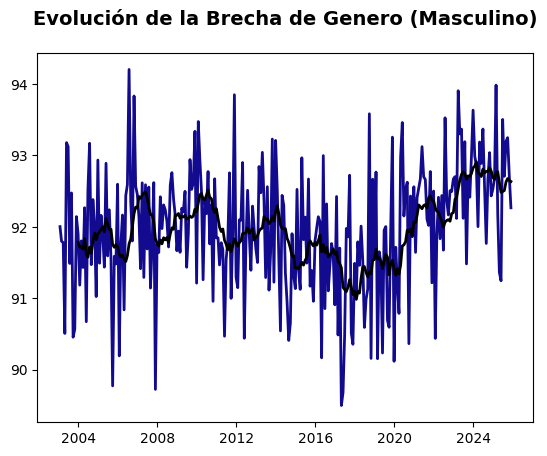

In [201]:
# Lineas de tendencias principal (Masculino)
plt.plot(df_trends.index, df_trends['ratio_masculino'], color='#120A8F', linewidth=2)

# Linea de tendencia suavizada 
plt.plot(df_trends.index, df_trends['ratio_masculino'].rolling(12).mean(),
         color='black', linewidth=2, linestyle='-', label='Tendencia Anual (Media Movil)')
plt.title(
    'Evolución de la Brecha de Genero (Masculino)',
    loc='center',
    fontsize=14,
    fontweight='bold',
    pad=20
)

## Analisis de densidad geográfica

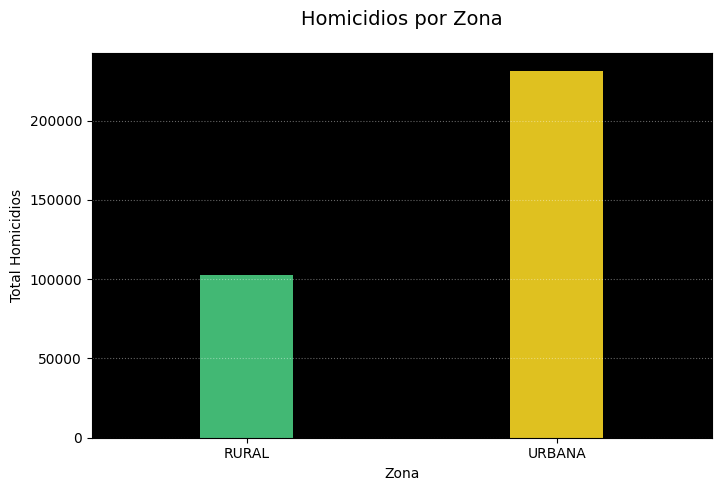

In [52]:
#  se crea sub df de la cantidad de homicidios por sexo.
df_zona = df[['zona','total_homicidios']].copy()
df_zona_agrupada = df_zona.groupby(['zona']).sum()

# Gestión de los patrones generales de visualización.
fig, ax = plt.subplots(figsize=(8,5), facecolor='white')
ax.set_facecolor('black')

# Visualización de la cantidad de homicidios por sexo.
sns.barplot(
    data=df_zona_agrupada,
    x='zona',
    y='total_homicidios',
    hue='zona',
    palette=colores_zona,
    estimator=sum,
    errorbar=None,
    ax=ax,
    width=0.3
)
# Definición de parametros estéticos.
ax.set_title('Homicidios por Zona', fontsize=14, color='black', pad=20)
ax.set_xlabel('Zona', fontsize=10, color='black')
ax.set_ylabel('Total Homicidios', fontsize=10, color='black')
ax.grid(axis='y', color='white',linestyle=':', alpha=0.4)

In [203]:
# Se genera un sub-DataFrame para total homicidios por municipio
df_mpio = df[['nom_mpio','total_homicidios']].copy()

# Agrupación por municipio
df_mpio_agrupado = (
    df_mpio
    .groupby(['nom_mpio'])
    .sum()
    .sort_values(by='total_homicidios',ascending=False)
    .reset_index()
)
df_mpio_agrupado.head()

,nom_mpio,total_homicidios
0,CALI,32579
1,"BOGOTÁ, D.C.",29363
2,MEDELLÍN,17866
3,BARRANQUILLA,8146
4,SAN JOSÉ DE CÚCUTA,7116


In [205]:
# # Se genera un sub-DataFrame para total homicidios por departamento
df_depto = df[['nom_depto','total_homicidios']].copy()

# Agrupación por departamento
df_depto_agrupado = (
    df_depto
    .groupby(['nom_depto'])
    .sum()
    .sort_values(by='total_homicidios', ascending=False)
    .reset_index()
)
df_depto_agrupado.head()

,nom_depto,total_homicidios
0,VALLE DEL CAUCA,65467
1,ANTIOQUIA,52500
2,"BOGOTÁ, D.C.",29363
3,CAUCA,14334
4,NORTE DE SANTANDER,13872


In [46]:
# Se hace un subset con los datos ncesarios 
df_zona_dia = df[['zona','dia_semana','nombre_dia_semana', 'total_homicidios']].copy()

# Se pivota la tabla en función de la zona 
df_pv_zona_dia = df_zona_dia.pivot_table(
    index=['dia_semana','nombre_dia_semana'],
    columns='zona',
    values='total_homicidios',
    aggfunc='sum' 
).copy()

# Se divie cada celda por la suma de su columna 
df_heatmapdata =  df_pv_zona_dia.apply(lambda x: x / x.sum(), axis=0) 

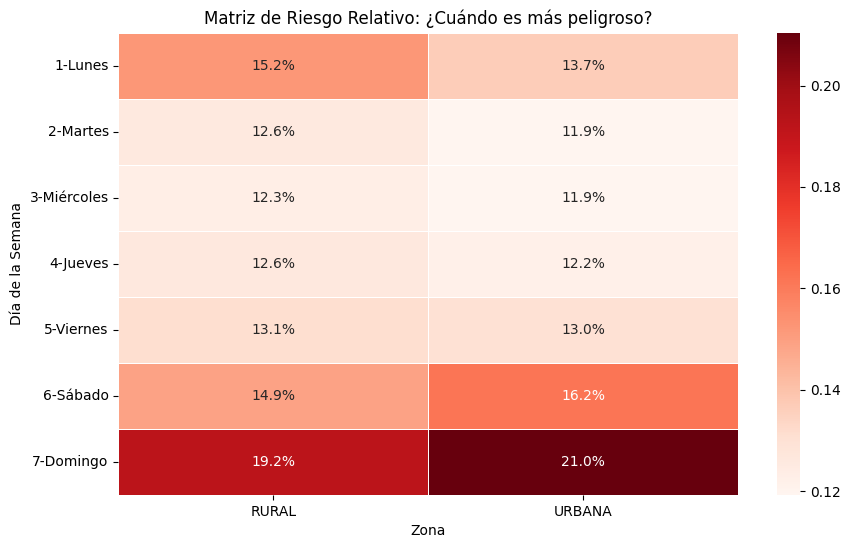

In [50]:
# Graficar

# Se define el tamaño de la gráfica 
plt.figure(figsize=(10,6))

sns.heatmap(
    df_heatmapdata,
    cmap='Reds',
    annot=True, 
    fmt='.1%', 
    linewidth=0.5)
plt.title('Matriz de Riesgo Relativo: ¿Cuándo es más peligroso?')
plt.ylabel('Día de la Semana')
plt.xlabel('Zona')
plt.show()

### Analísis temporal (Cuándo)

*Gráfico de linea anual (2003 - 2025)*


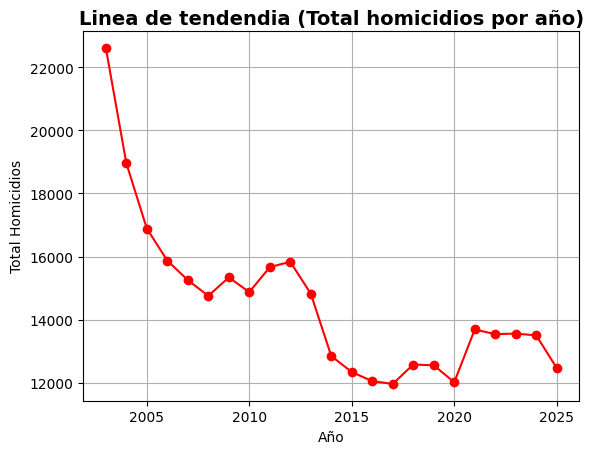

In [49]:
# Se define serie de tiempo para el estudio
df_anual = (
    df[['año', 'total_homicidios']]
        .groupby(['año'])
        .sum()
)

# Se gráfoca la linea de tiempo
plt.plot(df_anual.index, df_anual['total_homicidios'], color='red', marker='o')
plt.title(
    'Linea de tendendia (Total homicidios por año)',
    loc='center',
    pad=5,
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Año')
plt.ylabel('Total Homicidios')
plt.grid(True)
plt.show()

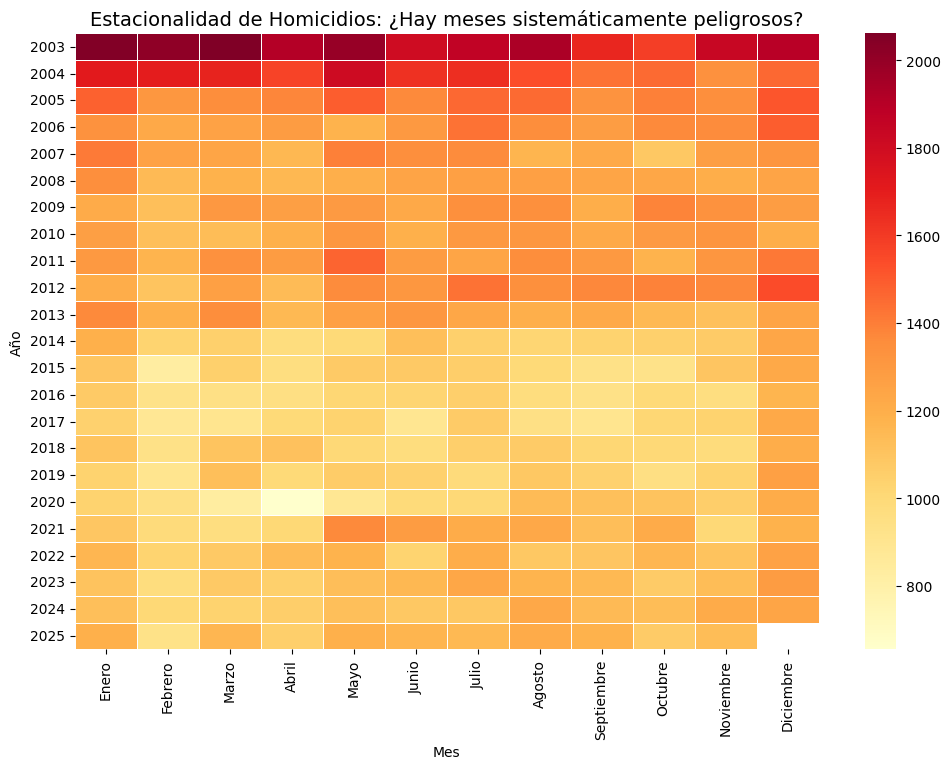

In [51]:
# Se crea un subset con la estacionalidad mensual 
df_estacionalidad = df[['año', 'nombre_mes','total_homicidios']]

# Se pivotan los datos para facilitar su analísis (heatmap)
heatmap_mensual = df_estacionalidad.pivot_table(
    index='año',
    columns='nombre_mes',
    values='total_homicidios',
    aggfunc='sum'
)

# Definir el orden cronológico de los meses (si no, saldrán alfabéticamente: Abril, Agosto...)
orden_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Se reordenan las columnas
heatmap_mensual = heatmap_mensual.reindex(columns=orden_meses)

plt.figure(figsize=(12, 8))

sns.heatmap(
    heatmap_mensual,
    cmap='YlOrRd',  # Amarillo a Rojo (seguro a peligroso)
    linewidths=0.5,
    annot=False,    # False para no llenar de números (solo patrones de color)
)
plt.title('Estacionalidad de Homicidios: ¿Hay meses sistemáticamente peligrosos?', fontsize=14)
plt.ylabel('Año')
plt.xlabel('Mes')
plt.show()

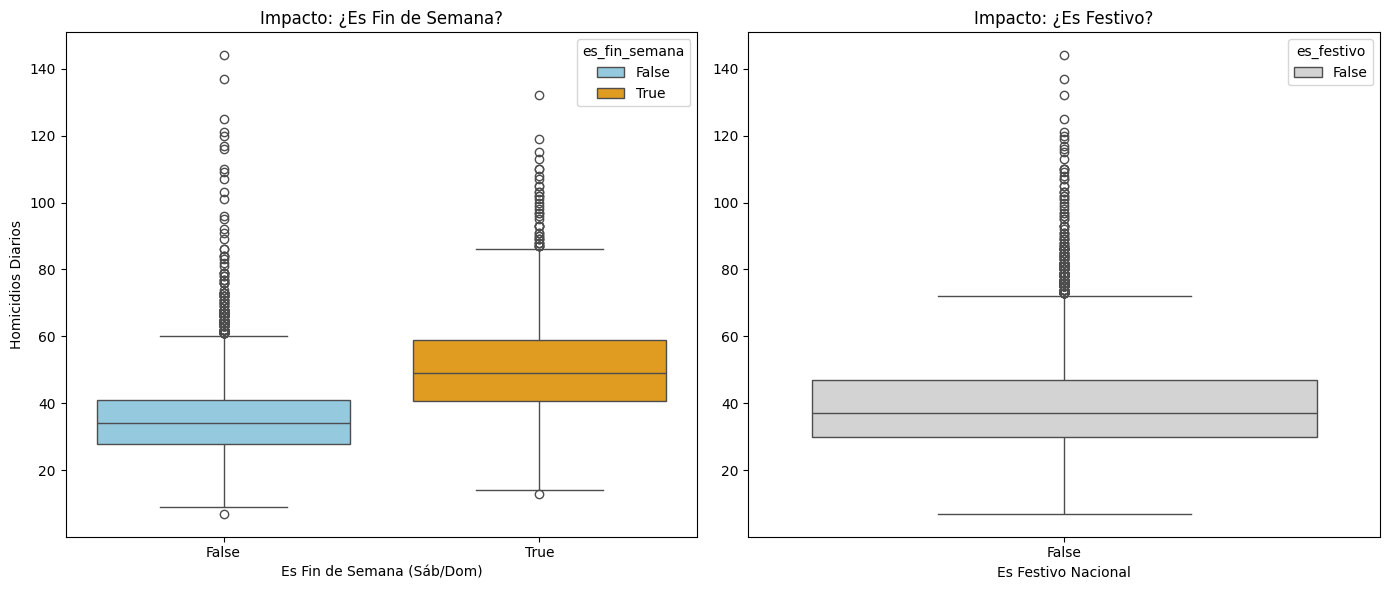

In [73]:
df_booleans = pd.read_sql_query(
    '''
    SELECT
        f.fecha,
        f.es_fin_semana,  -- TRUE si es Sábado o Domingo
        f.es_festivo,     -- TRUE si es Festivo Nacional
        SUM(h.cantidad) as total_diario
    FROM fact_homicidios h
    JOIN dim_fecha f ON h.fecha_key = f.fecha_key
    GROUP BY 1, 2, 3
    ''',
    engine
)
colores_bool = {'True': 'orange', 'False': 'skyblue', True: 'orange', False: 'skyblue'}


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Gráfico A: Impacto de FIN DE SEMANA (Nativo) ---
sns.boxplot(
    data=df_booleans, 
    x='es_fin_semana', 
    y='total_diario', 
    palette=colores_bool,
    hue='es_fin_semana',
    ax=axes[0]
)
axes[0].set_title('Impacto: ¿Es Fin de Semana?')
axes[0].set_xlabel('Es Fin de Semana (Sáb/Dom)')
axes[0].set_ylabel('Homicidios Diarios')


colores_festivo = {'True': 'red', 'False': 'lightgray', True: 'red', False: 'lightgray'}

# --- Gráfico B: Impacto de FESTIVO (Nativo) ---
sns.boxplot(
    data=df_booleans, 
    x='es_festivo', 
    y='total_diario', 
    palette=colores_festivo,
    hue='es_festivo',
    ax=axes[1]
)
axes[1].set_title('Impacto: ¿Es Festivo?')
axes[1].set_xlabel('Es Festivo Nacional')
axes[1].set_ylabel('') # Quitamos label redundante


plt.tight_layout()
plt.show()


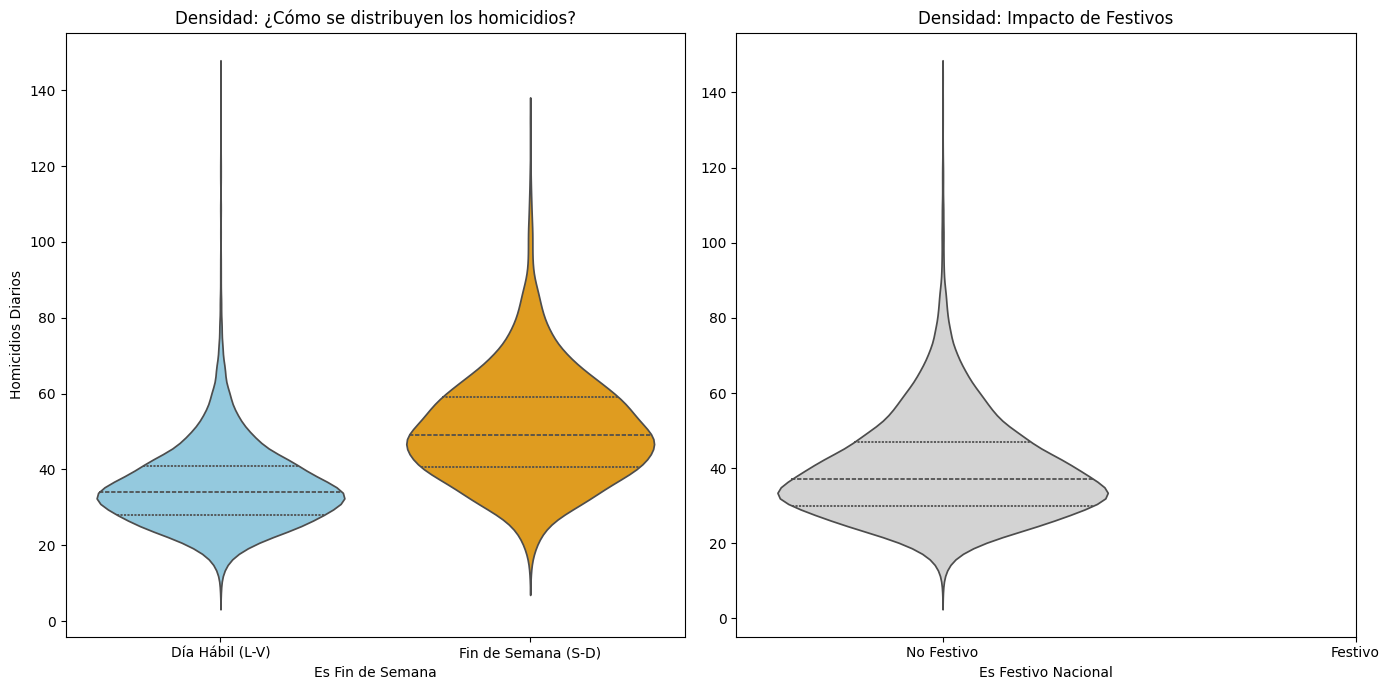

In [72]:
plt.figure(figsize=(14, 7))

# --- Gráfico A: Violín de FIN DE SEMANA ---
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, posición 1
sns.violinplot(
    data=df_booleans, 
    x='es_fin_semana', 
    y='total_diario', 
    hue='es_fin_semana',      # Obligatorio por warning
    palette=colores_bool,     # Usamos tu diccionario corregido
    legend=False,
    inner='quartile'          # Muestra líneas en los cuartiles (25%, 50%, 75%)
)
plt.title('Densidad: ¿Cómo se distribuyen los homicidios?')
plt.xlabel('Es Fin de Semana')
plt.ylabel('Homicidios Diarios')
plt.xticks([0, 1], ['Día Hábil (L-V)', 'Fin de Semana (S-D)'])

# --- Gráfico B: Violín de FESTIVO ---
plt.subplot(1, 2, 2) # Posición 2
sns.violinplot(
    data=df_booleans, 
    x='es_festivo', 
    y='total_diario', 
    hue='es_festivo', 
    palette=colores_festivo, 
    legend=False,
    inner='quartile'
)
plt.title('Densidad: Impacto de Festivos')
plt.xlabel('Es Festivo Nacional')
plt.ylabel('')
plt.xticks([0, 1], ['No Festivo', 'Festivo'])

plt.tight_layout()
plt.show()
